# Web Coverage Service - Accessing GeoMet data using owslib

In this notebook we'll connect to Environment Canada's GeoMet service and fetch data using the WCS standard. 

In [1]:
%matplotlib inline

from tempfile import NamedTemporaryFile

import matplotlib.pyplot as plt
import xarray as xr
from owslib.wcs import WebCoverageService

In [2]:
# NBVAL_IGNORE_OUTPUT

wcs_url = "http://geo.weather.gc.ca/geomet/?lang=en&service=WCS"

# Connect to service
wcs = WebCoverageService(wcs_url, version="2.0.1")
print(wcs.identification.title)

# List some of the content available
sorted(list(wcs.contents.keys()))[:10]

MSC GeoMet — GeoMet-Weather 2.36.3


['CAPS-WEonG_3km_AirTemp',
 'CAPS-WEonG_3km_BlowingSnow-Prob',
 'CAPS-WEonG_3km_BlowingSnowPresence',
 'CAPS-WEonG_3km_DewPointTemp',
 'CAPS-WEonG_3km_DominantPrecipType',
 'CAPS-WEonG_3km_Drizzle-Prob',
 'CAPS-WEonG_3km_FreezingDrizzle-Prob',
 'CAPS-WEonG_3km_FreezingPrecip-Prob',
 'CAPS-WEonG_3km_FreezingRain-Prob',
 'CAPS-WEonG_3km_IceFogVisibility']

Now let's get some information about a given layer, here the salinity. 

In [3]:
layerid = "OCEAN.GIOPS.3D_SALW_0000"
temp = wcs[layerid]
# Title
print("Layer title :", temp.title)
# bounding box
print("BoundingBox :", temp.boundingBoxWGS84)
# supported data formats - we'll use geotiff
print("Formats :", sorted(temp.supportedFormats))
# grid dimensions
print("Grid upper limits :", sorted(temp.grid.highlimits))

Layer title : None
BoundingBox : None
Formats : ['application/x-grib2', 'image/jpeg', 'image/netcdf', 'image/png', 'image/png; mode=8bit', 'image/tiff', 'image/vnd.jpeg-png', 'image/vnd.jpeg-png8', 'image/x-aaigrid']
Grid upper limits : ['1799', '849']


To request data, we need to call the `getCoverage` service, which requires us specifying the geographic projection, the bounding box, the resolution and format of the output. With GeoMet 2.0.1, we can now get layers in the netCDF format. 

In [4]:
format_wcs = "image/netcdf"
bbox_wcs = temp.boundingboxes[0]["bbox"]  # Get the entire domain
crs_wcs = temp.boundingboxes[0]["nativeSrs"]  # Coordinate system
w = int(temp.grid.highlimits[0])
h = int(temp.grid.highlimits[1])

print("Format:", format_wcs)
print("Bounding box:", bbox_wcs)
print("Projection:", crs_wcs)
print(f"Resolution: {w} x {h}")

output = wcs.getCoverage(
    identifier=[
        layerid,
    ],
    crs=crs_wcs,
    bbox=bbox_wcs,
    width=w,
    height=h,
    format=format_wcs,
)

Format: image/netcdf
Bounding box: (-80.1, -180.0, 89.9, 180.0)
Projection: http://www.opengis.net/def/crs/EPSG/0/4326
Resolution: 1799 x 849


We then save the output to disk, open it normally using xarray and plot it's variable. 

In [5]:
# NBVAL_IGNORE_OUTPUT

tempfile = NamedTemporaryFile(prefix=layerid, suffix=".nc", delete=False)

with open(tempfile.name, "wb") as fh:
    fh.write(output.read())
tempfile.name

'/tmp/OCEAN.GIOPS.3D_SALW_00004u5p49ge.nc'

Data variables:
    crs      |S1 1B ...
    Band1    (lat, lon) float32 6MB ...


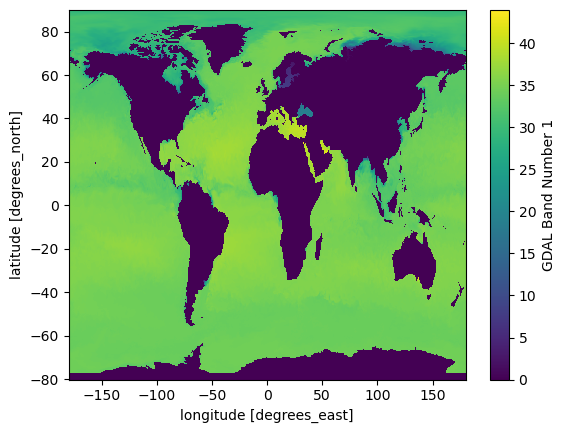

In [6]:
ds = xr.open_dataset(tempfile.name)
print(ds.data_vars)
ds.Band1.plot()
plt.show()

# Clean up
tempfile.close()